l'objectif de cette partie est de complementarisé l'approche précedentes dans l'utilsation des modèles VAR / VECM.
En effet , dans cette partie l'on va utiliser de nouveaux estimateurs premettant de ne pas devoir reduire le nombre de parametre à estimer pour notre VAR.
On utilise alors des `sparse` estimateur.

Au vu de ma lagMatrix nous ne sommes pas dans le contexte permettant d'utiliser des estimateurs sparse.

In [1]:
rm(list=ls())
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

In [2]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date <= as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2020 Q1 
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,2),frequency = 4)# Commence a 2020 Q2 --> 2021 Q2

In [3]:
suppressPackageStartupMessages(require(vars))
require(bigtime)
require(tidyverse)

Loading required package: bigtime

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ strucchange::boundary() masks stringr::boundary()
✖ dplyr::filter()         masks stats::filter()
✖ dplyr::lag()            masks stats::lag()
✖ MASS::select()          masks dplyr::select()



In [4]:
print("CORRESPONDANCE LABEL - NOMBRE SECTEURS")
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
lab.to.num

[1] "CORRESPONDANCE LABEL - NOMBRE SECTEURS"


lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


In [5]:
colnames(df.ts) <-lab.to.num$num
colnames(covid.ts) <- lab.to.num$num

 <hr>

 ## Dimension reduction

In [41]:
df <- as.data.frame(df.ts)
df <-df %>% as.matrix()
colnames(df) <- paste("DF",1:dim(df)[2],sep="")

In [42]:
#-----------------------------
# Plot function 
#require(tidyverse)
plot_series <- function(Y){
  as_tibble(Y) %>%
  mutate(Time = 1:n()) %>%
  pivot_longer(-Time, names_to = "Series", values_to = "vals") %>%
  mutate(Series = factor(Series, levels = colnames(Y))) %>%
  ggplot() +
  geom_line(aes(Time, vals)) + 
  facet_wrap(facets = vars(Series), ncol = 1) + 
  ylab("") +
  theme_bw()
}

# Lasso Estimation using L1 penalty on the autoregressive coefficients

In [43]:
VAR.HLAG <-sparseVAR(
    Y=scale(df),# We're using HLag estimators
    selection="cv"
)

In [44]:
VAR.L1 <- sparseVAR(Y=scale(df),  # standardising the data
                   selection = "cv", # using time series cross-validation
                   VARpen = "L1") # using the lasso penalty

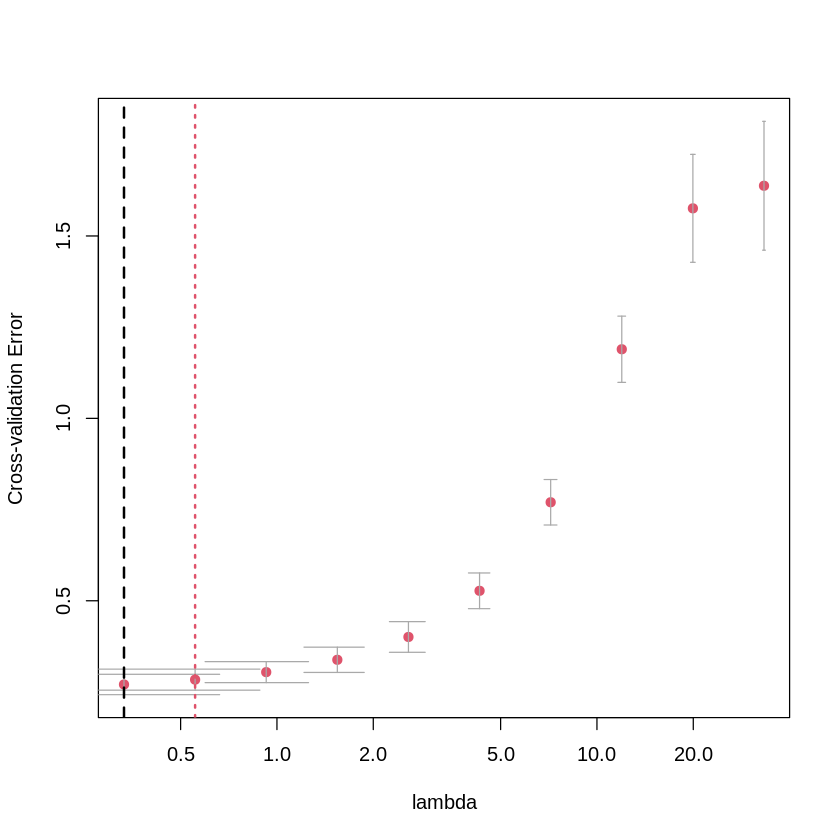

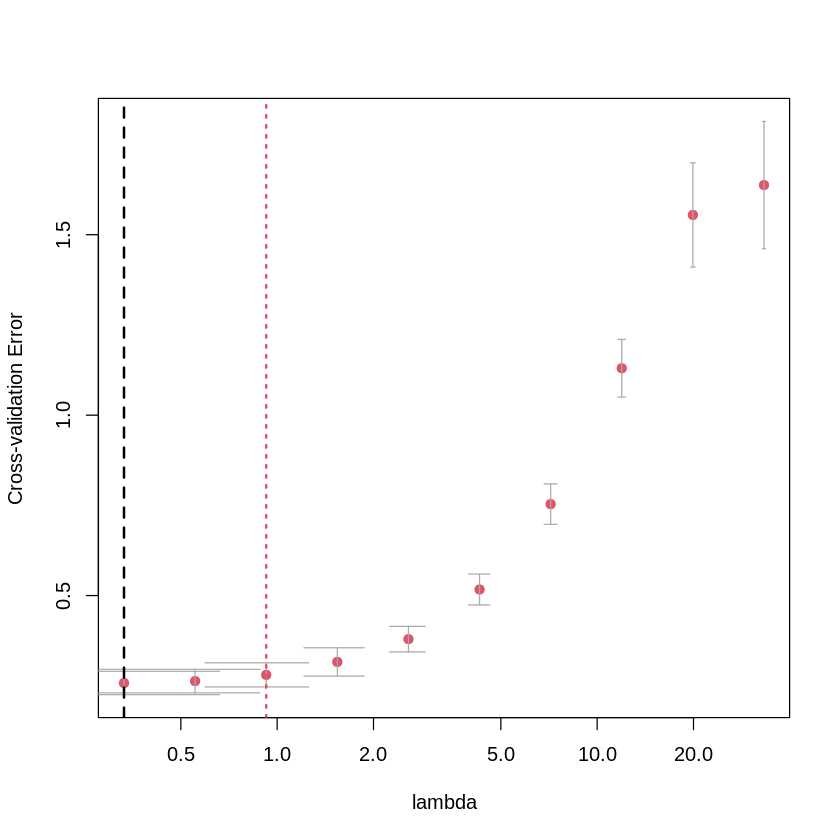

In [45]:
plot_cv(VAR.HLAG)
plot_cv(VAR.L1)

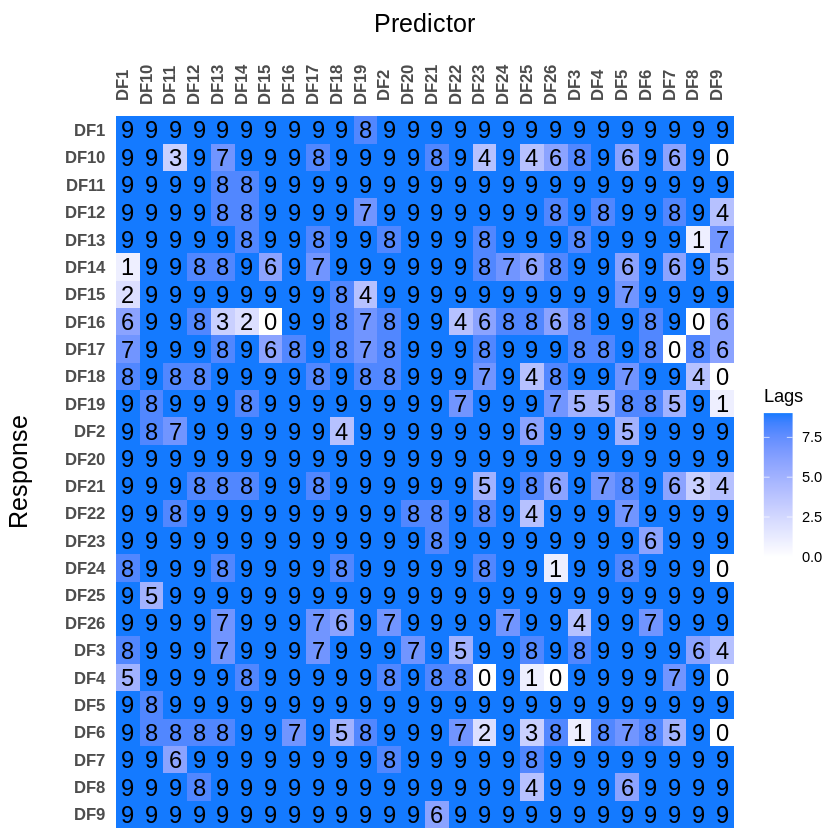

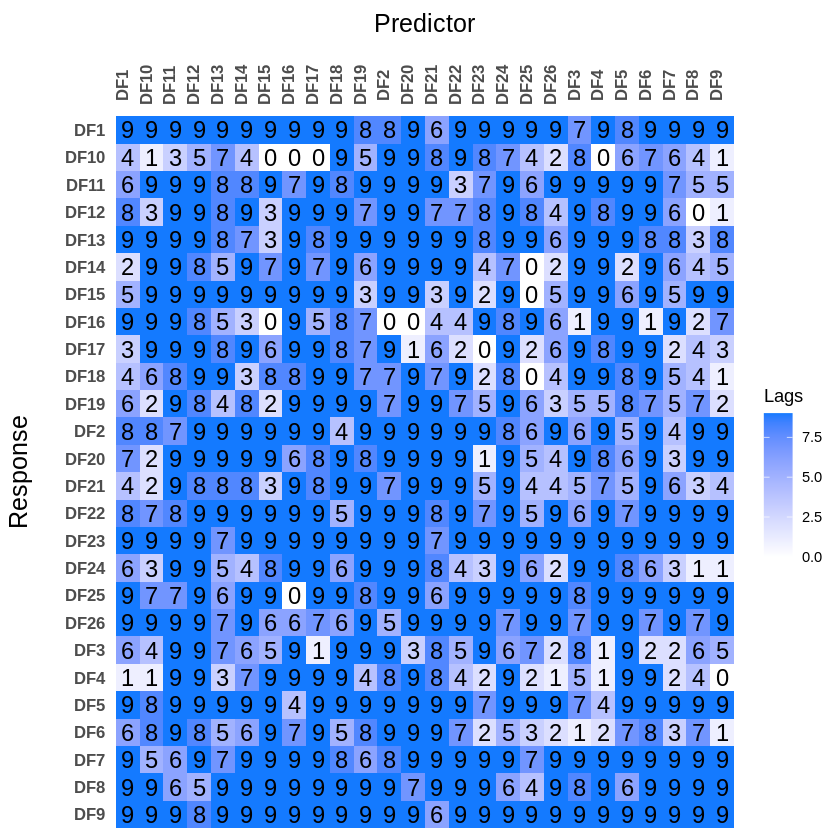

In [46]:
LhatL1 <- lagmatrix(fit=VAR.L1, returnplot=TRUE)
LhatHLag <- lagmatrix(fit=VAR.HLAG, returnplot=TRUE)

In [51]:
VAR.HLAG.bis <-sparseVAR(
    Y=scale(df),# We're using HLag estimators
    selection= "aic"
)
VAR.L1.bis <-sparseVAR(
    Y=scale(df),# We're using HLag estimators
    VARpen = "L1",
    selection="aic"

)

Warning message in get_ic_vals.bigtime.VAR(mod, verbose = verbose):
“IC selection is only recommended for cases in which p < T”




#### Selected the following lambda ####

     AIC      BIC       HQ 
33.26857 33.26857 33.26857 


#### Details ####

    lambda          AIC          BIC           HQ
1  33.2686 ==> -66.7848 ==> -66.7848 ==> -66.7848
2   19.944     -63.1675     -59.9076     -61.9804
3  11.9561     -52.6603     -38.5756     -47.5315
4   7.1675     -44.9285     -22.1087     -36.6188
5   4.2968     -30.5566       7.0166     -16.8745
6   2.5759     -11.2748      46.1925       9.6516
7   1.5442      25.2334     118.3932      59.1571
8   0.9257      81.0896     226.5342     134.0525
9    0.555     145.4891     350.7416     220.2308
10  0.3327      178.516     415.7412     264.9003


Warning message in get_ic_vals.bigtime.VAR(mod, verbose = verbose):
“IC selection is only recommended for cases in which p < T”




#### Selected the following lambda ####

     AIC      BIC       HQ 
33.21678 33.21678 33.21678 


#### Details ####

    lambda          AIC          BIC           HQ
1  33.2168 ==> -66.7848 ==> -66.7848 ==> -66.7848
2  19.9129     -59.0492     -51.5262     -56.3098
3  11.9375     -43.4629     -18.9714     -34.5444
4   7.1563     -25.5899      17.5001      -9.8989
5   4.2901       -0.715      67.7861      24.2293
6   2.5719      33.1725     135.3181      70.3683
7   1.5418      78.6341     224.2041     131.6427
8   0.9243     122.8267     310.9017     191.3132
9   0.5541     156.4501     377.3337     236.8838
10  0.3322     177.9153     419.2782     265.8063


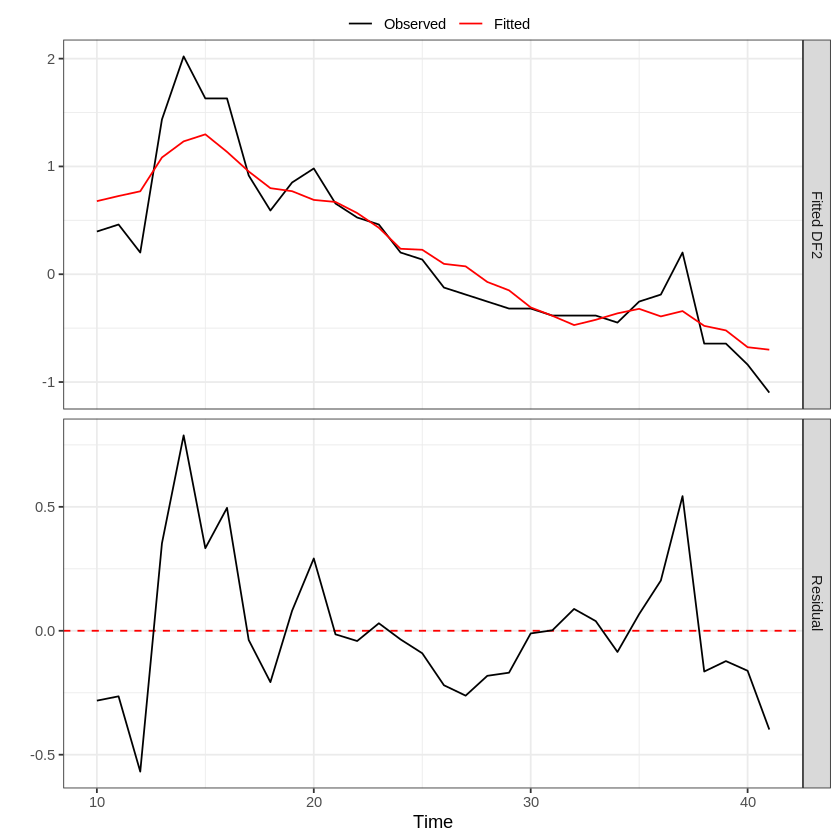

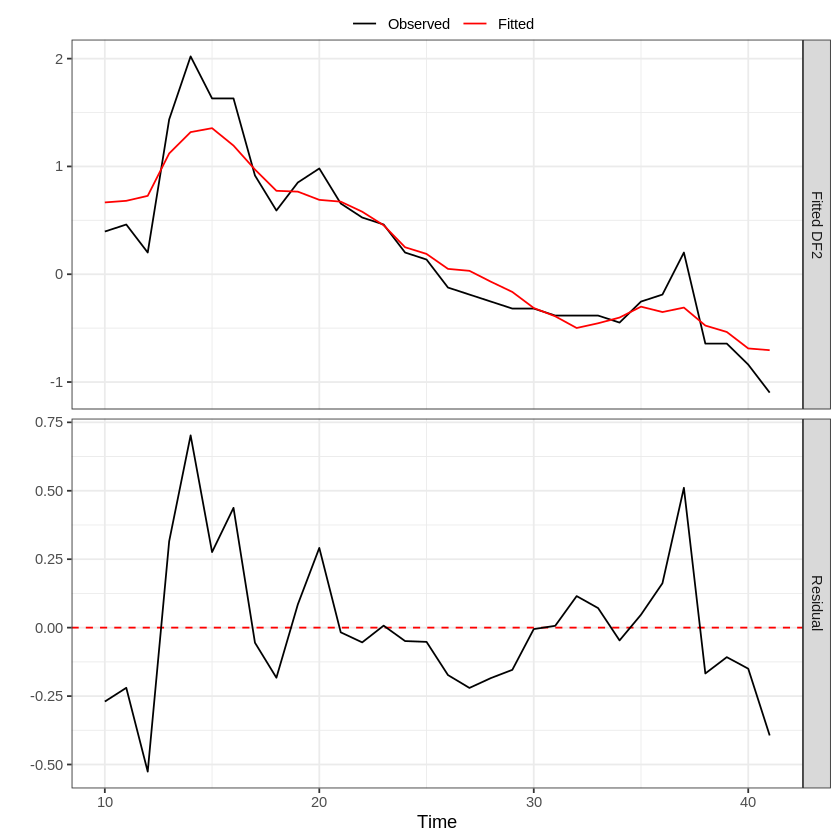

In [53]:
diagnostics_plot(VAR.HLAG,variable="DF2")
diagnostics_plot(VAR.L1,variable="DF2")

In [50]:
summary(VAR.L1)

             Length Class  Mode     
k               1   -none- numeric  
Y            1066   -none- numeric  
p               1   -none- numeric  
Phihat       6084   -none- numeric  
phi0hat        26   -none- numeric  
series_names   26   -none- character
lambdas        10   -none- numeric  
MSFEcv         10   -none- numeric  
MSFE_all       40   -none- numeric  
lambda_SEopt    1   -none- numeric  
lambda_opt      1   -none- numeric  
h               1   -none- numeric  
selection       1   -none- character

In [54]:
is.stable(VAR.HLAG)
is.stable(VAR.L1)

[1] TRUE

[1] TRUE

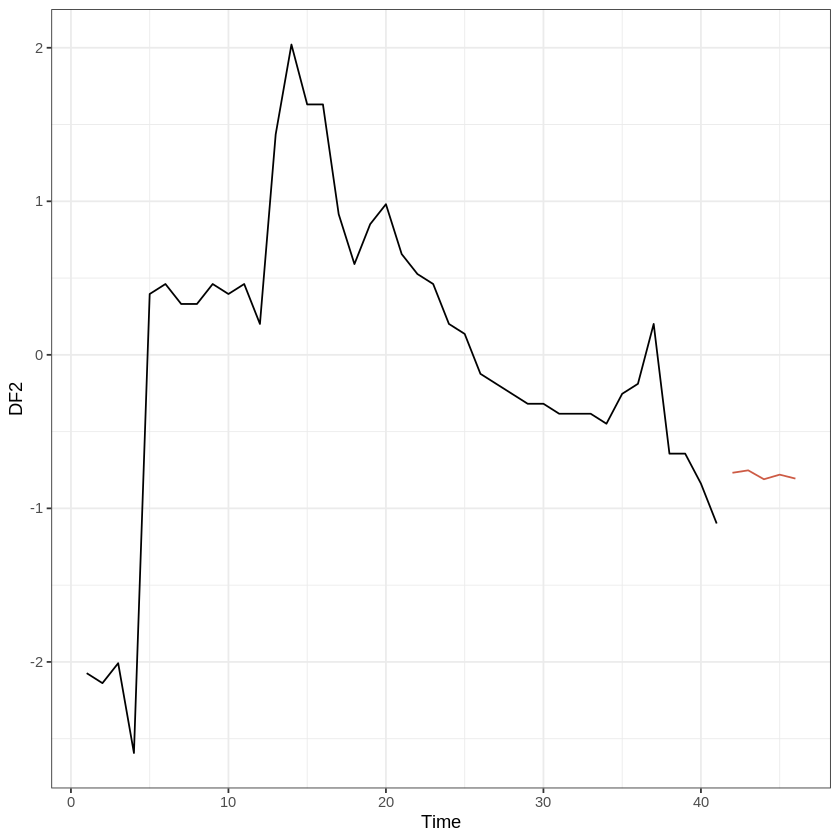

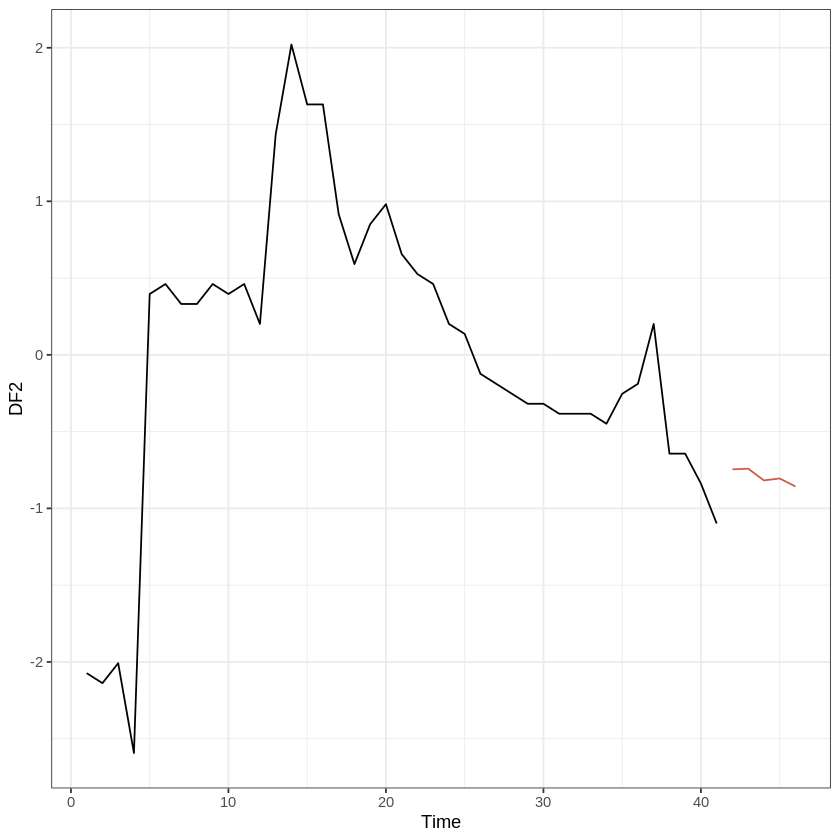

In [61]:
HLAG.mod.frct <-recursiveforecast(VAR.HLAG,h=5)
L1.mod.frct <-recursiveforecast(VAR.L1,h=5)



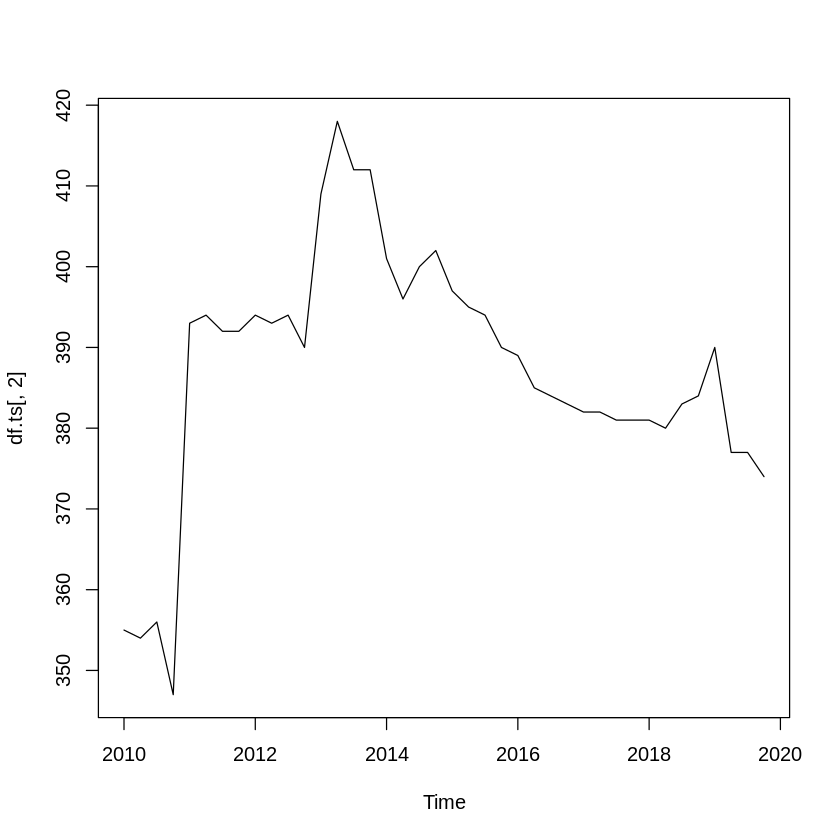

In [25]:

plot.ts(df.ts[,2])

$fcst
           DF1        DF2      DF3        DF4       DF5          DF6      DF7
[1,] -1.820157 -0.7456291 1.652309 -0.6232545 -1.741041  0.119147906 1.675461
[2,] -1.872033 -0.7413670 1.983398 -0.5306273 -1.984827  0.051868005 1.701096
[3,] -1.902070 -0.8177734 2.082267 -0.5105202 -1.845799 -0.057655547 1.712681
[4,] -2.015060 -0.8050299 1.806390 -0.5427558 -2.049595 -0.004544764 1.754096
[5,] -2.038016 -0.8574007 1.611558 -0.5456537 -2.036327  0.056259381 1.797918
          DF8      DF9       DF10     DF11      DF12      DF13       DF14
[1,] 1.319905 1.725774 -0.5971441 1.334823 -1.443548 -2.106644 -0.5903028
[2,] 1.299675 1.789567 -0.6035780 2.117268 -2.005755 -1.874082 -0.6081264
[3,] 1.391345 1.830665 -0.6295006 1.497668 -1.534659 -2.329957 -0.6547054
[4,] 1.516305 1.904915 -0.6571560 1.721055 -1.851193 -2.435381 -0.6218556
[5,] 1.563937 1.926668 -0.6809306 1.590270 -1.716202 -2.536951 -0.7288905
           DF15       DF16       DF17       DF18      DF19       DF20      DF21
[1

= > diff_inv or unsceld the series + the prediction 

Warning message in cbind(c(df[, i], pred), c(df[, i], obs)):
“number of rows of result is not a multiple of vector length (arg 1)”


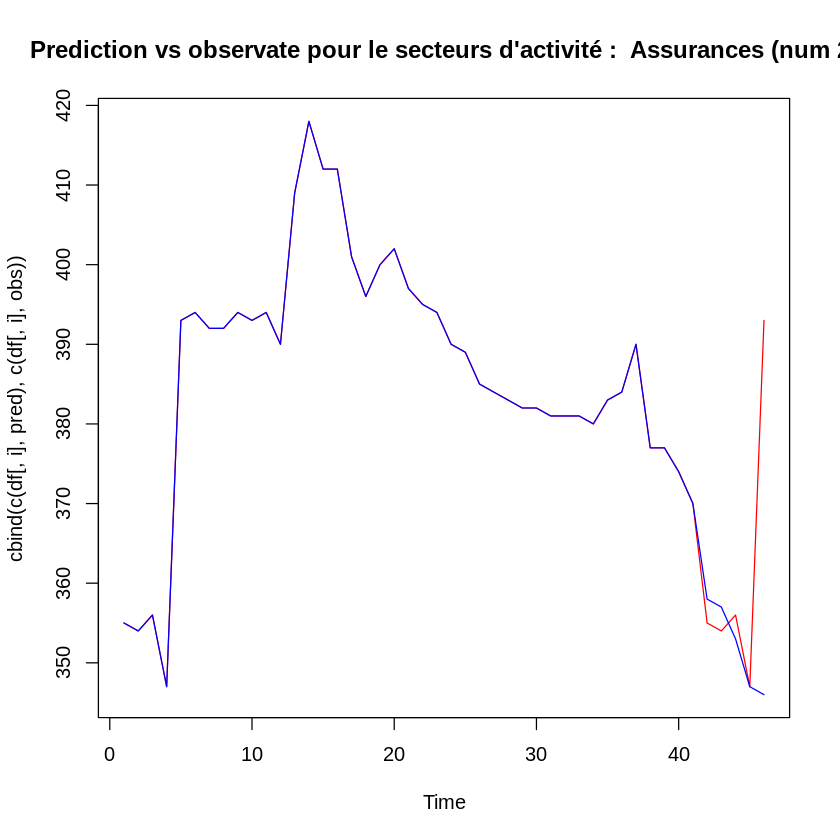

In [72]:
for (i in 2: 2){
    df.scaled <- scale(df)
    centered_scale <-attr(df.scaled,"scaled:center")[i]
    sd_scale <-attr(df.scaled,"scaled:scale")[i]
    

    VAR.forecast <- recursiveforecast(VAR.L1,h=5)
    pred <- VAR.forecast$frct[i]
    c <-rep(centered_scale[[1]],length(pred))
    scale <-rep(sd_scale[[1]],length(pred))
    pred <-pred*scale +c
    obs <- covid.ts%>%as.data.frame
    obs <- obs[,i]
    plot.ts(
        cbind(
            c(df[,i],pred),
            c(df[,i],obs)),
            plot.type="single",
            col=c("red","blue"),
            main="Prediction vs observate pour le secteurs d'activité :  Assurances (num 2)"
    )

}




In [98]:
for (i in 1:26){
df.scaled <- scale(df)
centered_scale <-attr(df.scaled,"scaled:center")[i]
sd_scale <-attr(df.scaled,"scaled:scale")[i]
#print(centered_scale)
#print(sd_scale)

VAR.forecast <- recursiveforecast(VAR.L1,h=5)

#print(VAR.forecast$fcst)
pred <- VAR.forecast$fcst[,i]
#print(pred)
c <-rep(centered_scale[[1]],length(pred))
scale <-rep(sd_scale[[1]],length(pred))
pred <-pred*scale +c
obs <- covid.ts%>%as.data.frame
obs <- obs[,i]
pred <-c(df[,i],pred)
obs <-c(df[,i],obs)
obs <- ts(obs,start=c(2010,1),frequency=4)
pred <- ts(pred,start=c(2010,1),frequency=4)
png(file=paste("plots/LASSO/forecasts/",i,".png",sep=""))
plot.ts(
        cbind(
            pred,
            obs
        ),
        lty=c(2,1),
        plot.type="single",
        col=c("blue","red"),
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[i],sep="")
)
legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
dev.off()
}


In [100]:
saveRDS(VAR.L1,file="LASSO_model/LASSO_L1.Rda")# Il a un AIC de 33.21 

 Big time github: https://github.com/ineswilms/bigtime